# Bloodsuger Prediction for

[Data description](https://www.sciencedirect.com/science/article/pii/S2352340924005262#bib0005)

[Paper](https://www.mdpi.com/1424-8220/21/21/7090)


**Aim of project**: Predict glucose values 1h in advance (with special focus on hyper-/hypoglycemia)

## Table of Contents
1. [Dataset Overview](#EDA)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)

Bloodsugar is the concentration of glucose molecules in the blood. It is either given in $mg/dl$ or $mmol/l$ \
Conversion between both units is given by:

$$mg/dl * 0.0555 = mmol/l$$
$$mmol/l * 18.02= mg/dl$$

A normal range is between 70 mg/dL (3.9 mmol/L) and 200 mg/dL (11.1 mmol/L). Concentration above is called hypergylcemia and below hypoglycemia. Both hyper- and hypoglycemia can be dangerous. Severe hypoglycemia (< 54 mg/dL or 3.0 mmol/L)  can cause life threatening coma and should acted on immediately. Prolonged hyperglycemia cause ketoacidosis, which leads to dehydration, confusion and possibly loss of consciousness.

In healthy people cells in the pancreas will release insulin or glucagon to lower or raise the blood glucose level based on a feedback-loop.
Type 1 Diabetes Mellitus (T1DM) is an autoimmune disorder in which the immune system attacks and destroy the insulin-producing beta cell in the pancreas. Without insulin production the body cannot regulate the amount of glucose (sugar) in the bloodstream. Without careful management, this can be life-threatening and so those with the condition need to inject insulin to manage their blood glucose levels themselves. There are many different factors that impact blood glucose levels, including eating, physical activity, stress, illness, sleep, alcohol, and many more, so calculating how much insulin to give is complex. The continuous need to think about how an action may impact blood glucose levels and what to do to counteract it is a significant burden for those with T1DM.

An important part of T1DM management is working out how blood glucose levels are going to change in the future. Algorithms of varying levels of complexity have been developed that perform this prediction but the messy nature of health data and the numerous unmeasured factors mean there is a limit to how effective they can be.

![](https://cdn.prod.website-files.com/622154d5a1d5c02e596f4511/62f2bee4de0117f1ec10c745_BloodGlucoseChart.jpeg)

# Setup
Download the data from the published repository and load the preprocessed data in pandas

In [ ]:
!wget "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3hbcscwz44-1.zip" -O data.zip
!unzip -q data.zip -d Data

--2025-01-22 08:50:50--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3hbcscwz44-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.2.234, 52.92.36.74, 3.5.66.116, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.2.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81460176 (78M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  77.69M  10.8MB/s    in 20s     

2025-01-22 08:51:11 (3.97 MB/s) - ‘data.zip’ saved [81460176/81460176]



In [ ]:
import glob
import random
from pathlib import Path

from functools import reduce

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import zscore

In [ ]:
subj_data = {}

for path in sorted(glob.glob("Data/HUPA-UCM Diabetes Dataset/Preprocessed/*.csv")):
    id = int(path.split("/")[-1][4:8])
    subj_id = f'P{id:02d}'
    df = pd.read_csv(path, sep=';', date_format="%Y-%m-%dT%H:%M:%S",
                                 index_col="time")
    df.insert(0, 'subj', subj_id)
    df = df.rename({
        'calories': 'burned_calories',
        'basal_rate': 'basal_insulin',
        'bolus_volume_delivered': 'bolus_insulin',
    }, axis=1)

    #if id == 1: # fix the wierd rippling in glucose data for this patient
    #    df['glucose'] = df['glucose'].rolling(3, center=True).mean()

    subj_data[subj_id] = df

#df_all = pd.concat(subj_data).reset_index()

def get_subj(id, df=None):
    subj_df = subj_data[id] if df is None else df[df.subj == id]
    if "time" in subj_df.columns:
        subj_df = subj_df.set_index('time')
    return subj_df.copy()

def all_subjs():
    return pd.concat(subj_data).reset_index()

display(get_subj('P01').head().round(2))

subj  glucose  burned_calories  heart_rate  steps  \
time                                                                    
2018-06-13 18:40:00  P01    332.0             6.36       82.32   34.0   
2018-06-13 18:45:00  P01    326.0             7.73       83.74    0.0   
2018-06-13 18:50:00  P01    330.0             4.75       80.53    0.0   
2018-06-13 18:55:00  P01    324.0             6.36       89.13   20.0   
2018-06-13 19:00:00  P01    306.0             5.15       92.50    0.0   

                     basal_insulin  bolus_insulin  carb_input  
time                                                           
2018-06-13 18:40:00           0.09            0.0         0.0  
2018-06-13 18:45:00           0.09            0.0         0.0  
2018-06-13 18:50:00           0.09            0.0         0.0  
2018-06-13 18:55:00           0.09            0.0         0.0  
2018-06-13 19:00:00           0.08            0.0         0.0

## Helper methods

In [ ]:
def bg_to_mmol(bg_mg):
    return bg_mg * 0.0555

def bg_to_mg(bg_mmol):
    return bg_mmol * 18.02

def swap_columns(df, col1, col2):
  cols = list(df.columns)
  cols[col1], cols[col2] = cols[col2], cols[col1]
  return df.loc[:,cols]

def subj_to_long_format(df, id_vars=['time'], value_vars=None):
    if value_vars is None:
        value_vars = df.columns.to_list()
        value_vars.remove('subj')
    return pd.melt(df.reset_index(), id_vars, value_vars)

def random_day(ts):
    # find a random day included in ts.index
    ts_days = pd.date_range(subj.index.min(), subj.index.max(), freq='d')
    return random.choice(ts_days).date()


def approx_interpolated_periods(ts, min_length=5, eps=1e-5, smoothing_win=-1):
    # Calculate second difference
    second_diff = ts.diff().diff()
    if smoothing_win > 1:
        second_diff = second_diff.rolling(window=smoothing_win, center=True, win_type="hamming").mean()
    # Identify regions where second difference is approximately zero
    smooth_regions_mask = second_diff.abs() < eps  # Adjust threshold as needed

    # filter short periods
    period_lengths = smooth_regions_mask.groupby((smooth_regions_mask != smooth_regions_mask.shift()).cumsum()).transform('sum')
    period_mask = (period_lengths >= min_length)

    return period_mask


def plot_gaps(ts, missing_mask, min_length=None):

    # Group by consecutive interpolated periods to find start and end indices
    interpolated_groups = (missing_mask != missing_mask.shift()).cumsum()
    interpolated_regions = (
        ts.index.to_series()
        .groupby(interpolated_groups)
        .agg(["first", "last", "size"])
        .loc[missing_mask.groupby(interpolated_groups).any()]
    )
    if min_length is not None:
        interpolated_regions = interpolated_regions[interpolated_regions["size"] >= min_length]
    else:
        min_length = interpolated_regions["size"].min()

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Interpolated Time Series', color='blue', zorder=1)

    # Overlay red rectangles for interpolated regions
    for _, row in interpolated_regions.iterrows():
        plt.axvspan(row["first"], row["last"], color="red", alpha=0.3,
                    label=f'Interpolated Period (>= {min_length} steps)')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Time Series with Interpolated Periods Highlighted")
    plt.xlabel("Date")
    plt.ylabel(ts.name or "Value")
    plt.grid(True)
    plt.show()



def show_interactive_ts_plot(df, var_names = None, normalization="None", title="",
                             show_first_only=False, groups={}, layout=None):
    """
    input:
        df: pd.DataFrame
        var_names: list of column names
        normalization: 'None', 'MinMax', 'ZScore' - which normalization to apply
        hide_all: bool - if True, all traces will be hidden at first
    """
    if var_names is None:
        var_names = df.select_dtypes(include=['number']).columns.to_list()

    for k, col in enumerate(var_names):
        if normalization == 'MinMax':
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        elif normalization == 'ZScore':
            df[col] = zscore(df[col])

    fig = go.Figure()
    for k, col in enumerate(var_names):
        if groups:
            group = next(key for key, val in groups.items() if col in val)
            first_group = next(iter(groups))
            visible = 'legendonly' if show_first_only and group!=first_group else True
            fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, visible=visible,
                                     legendgroup=group, legendgrouptitle_text=group))
        else:
            visible = 'legendonly' if show_first_only and (k>0) else True
            fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, visible=visible))
    fig.update_layout(
        title = title,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    dict(count=7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
    if layout is not None:
        fig.update_layout(layout)

    fig.show()


def show_interactive_subplots(df, var_names=None, layout=None):
    if var_names is None:
        var_names = df.select_dtypes(include=['number']).columns.to_list()
    fig = make_subplots(rows=len(cols), cols=1, shared_xaxes=True, subplot_titles=var_names)
    for k, col in enumerate(var_names):
        fig.append_trace(go.Scatter(x=df.index, y=df[col], name=col), row=k+1, col=1)

    fig.update_layout(
        yaxis = dict(
            fixedrange = True,
        ),
        showlegend=False
    )
    if layout is not None:
        fig.update_layout(layout)
    fig.show()


def impute_iterative_sklearn(df, var_names=None, random_state=42, **kwargs):
  from sklearn.experimental import enable_iterative_imputer
  from sklearn.impute import IterativeImputer

  if var_names is None:
      var_names = df.select_dtypes(include=['number']).columns.to_list()

  imp = IterativeImputer(max_iter=10, **kwargs)
  results = imp.fit_transform(df[var_names])
  return pd.DataFrame(results, index=df.index, columns=var_names)


def impute_em(X, max_iter = 3000, eps = 1e-08):
    '''(np.array, int, number) -> {str: np.array or int}
    Expectation–maximization algorithm
    by: https://joon3216.github.io/research_materials/2019/em_imputation_python.html
    Precondition: max_iter >= 1 and eps > 0

    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''

    nr, nc = X.shape
    C = np.isnan(X) == False

    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1

    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))

    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1

    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }

    return result

def strfdelta(tdelta, fmt='{D:02}d {H:02}h {M:02}m {S:02}s'):
    """Convert a pd.Timedelta object , datetime.timedelta object or a regular number to
    a custom-formatted string, just like the stftime() method does for datetime.datetime
    objects.

    The fmt argument allows custom formatting to be specified.  Fields can
    include seconds, minutes, hours, days, and weeks.  Each field is optional.

    Some examples:
        '{D:02}d {H:02}h {M:02}m {S:02}s' --> '05d 08h 04m 02s' (default)
        '{W}w {D}d {H}:{M:02}:{S:02}'     --> '4w 5d 8:04:02'
        '{D:2}d {H:2}:{M:02}:{S:02}'      --> ' 5d  8:04:02'
        '{H}h {S}s'                       --> '72h 800s'
    """

    from string import Formatter

    # Convert tdelta to integer seconds.
    if isinstance(tdelta, object):
        remainder = int(tdelta.total_seconds())
    elif isinstance(tdelta, (int, float)):
        remainder = int(tdelta)

    f = Formatter()
    desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]
    possible_fields = ('W', 'D', 'H', 'M', 'S')
    constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
    values = {}
    for field in possible_fields:
        if field in desired_fields and field in constants:
            values[field], remainder = divmod(remainder, constants[field])
    return f.format(fmt, **values)


def create_lag_features(df, var_names=None, max_past='1h', lag_step='5min',
                        lag_start='0', freq='5min', fmt_str='{H:02}:{M:02}',
                        group_by=None, sep='-'):
    lag_features = {}

    if var_names is None:
        var_names = df.select_dtypes('number').columns
    elif isinstance(var_names, str):
        var_names = [var_names]

    if group_by:
        df = df.groupby(group_by)
    for col in var_names:
        for offset in pd.timedelta_range(lag_start, max_past, freq=lag_step):
          offset_str = strfdelta(offset, fmt_str)
          lag_features[f'{col}{sep}{offset_str}'] = df[col].shift(offset // freq)
    lag_df = pd.concat(lag_features, axis=1)
    return lag_df


def add_lag_features(df, var_names=None, **kwargs):
    return pd.concat([df, create_lag_features(df, var_names, **kwargs)], axis=1)


def impute_with_lags(df, target, covariates=[], max_past='3d', lag_step='1d', group_by='subj'):
    df_lags = create_lag_features(df, var_names=target, max_past=max_past, group_by=group_by,
                                lag_step=lag_step, lag_start=lag_step, fmt_str='{H:02}h')
    df_imp = pd.concat([df[[target, *covariates]], df_lags], axis=1)
    return impute_iterative_sklearn(df_imp)[target]


# remove day's where a variable (e.g. glucose) is not tracked. Optionally keep partially tracked days.
# does change the datetime index if reindex is not deactived
def remove_gap_days(subj_df, var_name='glucose', drop_ratio=0.5,
                    reindex=True, verbose=False):
    days_with_gaps_group = subj_df[var_name].isna().groupby(pd.Grouper(level='time',freq='1D'))
    days_with_gaps = days_with_gaps_group.transform(lambda x: x.sum()/len(x)) >= drop_ratio
    if verbose:
        removed_days = len(np.unique(subj_df[days_with_gaps].index.date))
        print(f"Removed {removed_days} days with missing {var_name} data from {subj_df.subj.iloc[0]}")
    subj_df = subj_df[~days_with_gaps]
    if reindex:
        subj_df = subj_df.reset_index().rename(columns={'time': 'old_time'})
        #print(subj_df['old_time'].min(), sum(~days_with_gaps))
        subj_df.index = pd.date_range(subj_df['old_time'].min(), periods=sum(~days_with_gaps),
                                      freq='5min', name='time')
    return subj_df

# EDA

## Single subject

In [ ]:
subj = get_subj('P03') # use subject P02 as example
subj_id = subj['subj'].iloc[0]

In [ ]:
# Let's look at some statistics
display(subj.describe().round(1))

glucose  burned_calories  heart_rate   steps  basal_insulin  \
count   3770.0           3770.0      3770.0  3770.0         3770.0   
mean     143.3              9.3        78.1    27.4            0.1   
std       61.3              5.3        12.7    61.3            0.0   
min       44.0              5.4        51.2     0.0            0.0   
25%       95.4              5.5        69.5     0.0            0.0   
50%      129.0              6.9        77.2     0.0            0.1   
75%      181.0             11.4        86.2    26.0            0.1   
max      366.0             47.0       148.9   595.0            0.1   

       bolus_insulin  carb_input  
count         3770.0      3770.0  
mean             0.1         0.1  
std              0.5         1.0  
min              0.0         0.0  
25%              0.0         0.0  
50%              0.0         0.0  
75%              0.0         0.0  
max              9.1        13.0

Some variables seem to be oddly distributed. Also the glucose levels are partially in unhealhty regions.

Let's see this visually:

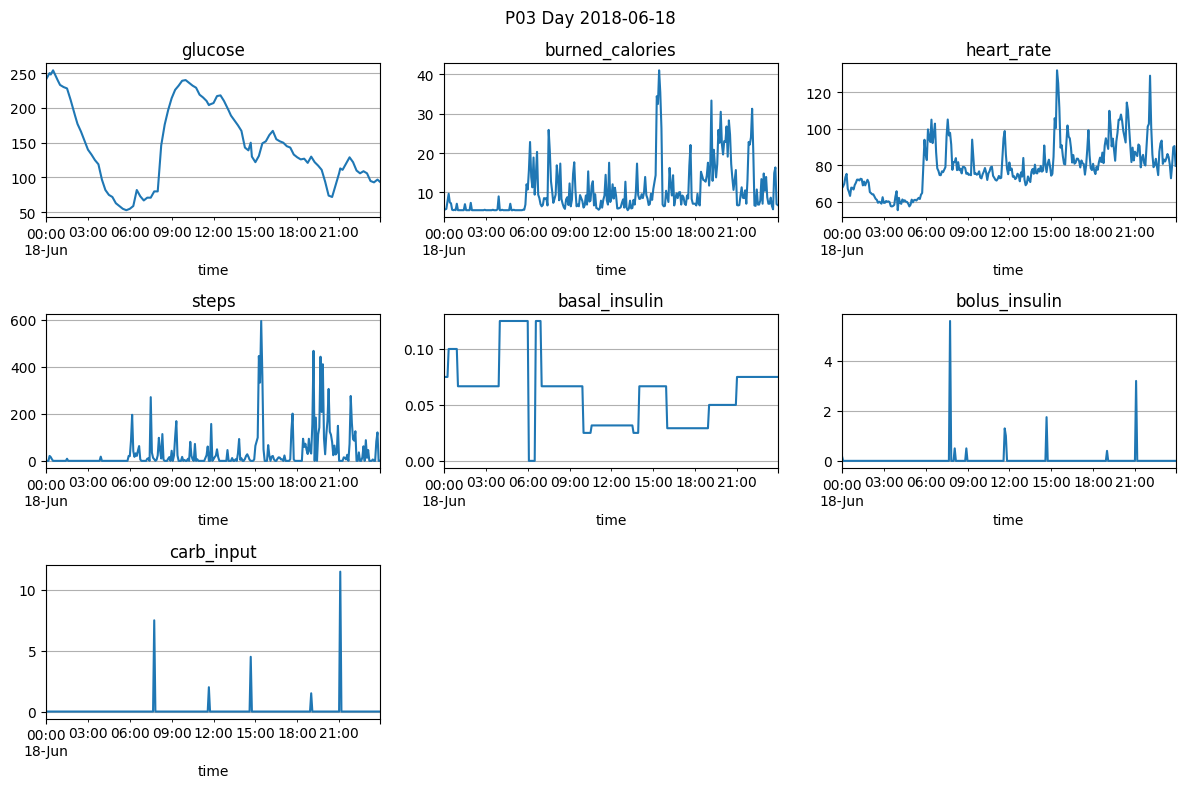

In [ ]:
# choose a random day to visualize
sample_day = random_day(subj)
subj_day = subj[subj.index.date == sample_day]

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(12, 8))
axes = axes.flatten()

numeric_cols = subj.select_dtypes(include=['number']).columns.to_list()
for i, col in enumerate(numeric_cols):
    subj_day[col].plot(grid=True, ax=axes[i])
    axes[i].set_title(col)

# Hide unused axes
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

fig.suptitle(f"{subj_id} Day {sample_day}")
plt.tight_layout()
plt.show()

It seem's like some of the variable are highly correlated. Let's look at a correlation plot!

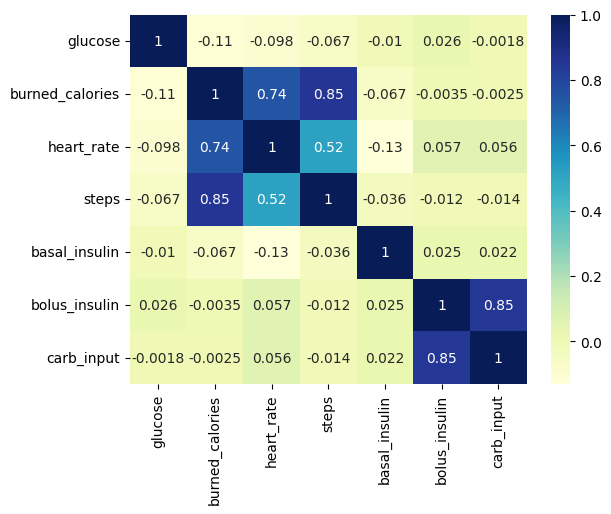

In [ ]:
dataplot = sns.heatmap(subj.corr(numeric_only=True), cmap="YlGnBu", annot=True)

Explaination:

The carb_input was measured by the glucose meter and used to determine the bolus_volume_delivered. \
Burned_calories, heart_rate and steps were all measured using a fitness tracker. Burned_calories were properly approximated using heart_rate and steps

### Interactive plots for further analysis

In [ ]:
subj_df = get_subj('P01')

# different normalization can be pretty helpful to see dependencies between variables on different scales
# options: 'ZScore', 'MinMax', 'None'
show_interactive_ts_plot(subj_df, normalization='MinMax', show_first_only=True)

In [ ]:
subj_df = get_subj('P09')

# different normalization can be pretty helpful to see dependencies between variables on different scales
# options: 'ZScore', 'MinMax', 'None'
show_interactive_ts_plot(subj_df, normalization='MinMax', show_first_only=True)

In [ ]:
subj_df = get_subj('P04')

# different normalization can be pretty helpful to see dependencies between variables on different scales
# options: 'ZScore', 'MinMax', 'None'
show_interactive_ts_plot(subj_df, normalization='MinMax')

Some findings:
- There are gaps in the measurement. Gaps in glucose and heart_rate got linearly interpolated, in others set to zero
- P01: wierd rippling effect in glucose levels -> smooth the curve
- P09: only limited insulin readings! DON'T USE!
- P26 -> long gap, bad carb tracking,
- P18: no insulin pump => no carb measurement / bolus volume

In [ ]:
subj_df = get_subj('P01')
cols = ['glucose', 'heart_rate', 'basal_insulin', 'bolus_insulin']
show_interactive_subplots(subj_df, cols)

## Intersubject analysis

In [ ]:
df_all = all_subjs()

How many timepoints to we have per subject?

In [ ]:
days_per_subj = df_all.groupby('subj').time.agg(lambda t: (t.max()-t.min()).days)
for k,v in days_per_subj.items():
    print(f"{k}: {v} days ({100*v/days_per_subj.sum():.2f}%)")

P01: 14 days (1.32%)
P02: 11 days (1.04%)
P03: 13 days (1.22%)
P04: 11 days (1.04%)
P05: 13 days (1.22%)
P06: 7 days (0.66%)
P07: 13 days (1.22%)
P09: 13 days (1.22%)
P10: 10 days (0.94%)
P11: 13 days (1.22%)
P14: 13 days (1.22%)
P15: 13 days (1.22%)
P16: 13 days (1.22%)
P17: 12 days (1.13%)
P18: 13 days (1.22%)
P19: 12 days (1.13%)
P20: 9 days (0.85%)
P21: 8 days (0.75%)
P22: 13 days (1.22%)
P23: 13 days (1.22%)
P24: 10 days (0.94%)
P25: 13 days (1.22%)
P26: 140 days (13.18%)
P27: 573 days (53.95%)
P28: 89 days (8.38%)


In [ ]:
big_subjs = ['P26','P27','P28']
print(f"{100*days_per_subj[days_per_subj.index.isin(big_subjs)].sum() / days_per_subj.sum():.2f}% of the data is from {big_subjs}")

"75.52% of the data is from ['P26', 'P27', 'P28']"

- Over 50% of the dataset is just one subject (P27)
- ~75% is from P26, P27 or P28
- all other just contribute ~1% each

In [ ]:
# calculate some avg day statistics for each subject
subj_statistics = df_all.groupby('subj').agg(['mean', 'min', 'max']).round(1)
# mean of day's total makes more sense for some of the variables
mean_day_total = df_all.groupby(['subj', pd.Grouper(key='time',freq='1D')]).sum().groupby(level='subj').agg(['mean', 'min', 'max']).round()

subj_statistics = pd.concat([subj_statistics[['glucose', 'heart_rate']],
                             mean_day_total[['steps', 'basal_insulin', 'bolus_insulin', 'burned_calories', 'carb_input']]],
                            axis=1)

display(subj_statistics.transpose())

subj                      P01      P02      P03      P04      P05      P06  \
glucose         mean    181.4    113.5    143.3    180.4    147.7    165.2   
                std      70.6     59.1     61.3     83.0     49.8     84.7   
                min      40.0     40.0     44.0     40.0     40.0     42.0   
                max     444.0    310.0    366.0    411.0    379.0    438.0   
heart_rate      mean     80.8     66.7     78.1     78.1     84.5     65.6   
                std      12.9     12.0     12.7      9.2     11.0     14.3   
                min      53.5     39.4     51.2     59.9     32.4     41.4   
                max     167.3    118.1    148.9    149.6    124.2    157.7   
steps           mean   5316.0  10402.0   7381.0   8147.0   3714.0   8653.0   
                min    1276.0      0.0    502.0   5235.0      0.0   5013.0   
                max   10918.0  14937.0  11875.0  10475.0  12831.0  12847.0   
basal_insulin   mean     14.0     23.0     15.0     19.0     18.0     19.0   
                min       3.0      1.0      2.0      8.0      8.0      8.0   
                max      16.0     26.0     18.0     23.0     19.0     23.0   
bolus_insulin   mean     11.0     19.0     19.0     40.0      7.0     25.0   
                min       4.0      8.0      0.0     14.0      4.0      7.0   
                max      15.0     34.0     28.0     49.0     11.0     36.0   
burned_calories mean   1617.0   2701.0   2509.0   2842.0   1531.0   2505.0   
                min     575.0     94.0    272.0   1352.0    860.0   1155.0   
                max    1979.0   3435.0   3031.0   3430.0   2127.0   3241.0   
carb_input      mean      8.0     53.0     31.0    168.0      6.0     25.0   
                min       4.0      0.0      0.0      0.0      3.0     12.0   
                max      12.0    135.0     40.0    320.0     10.0     37.0   

subj                      P07      P09      P10      P11  ...      P19  \
glucose         mean    173.2    193.7    135.9    159.1  ...    162.9   
                std      78.7     46.1     57.6     57.1  ...     60.5   
                min      40.0    100.0     41.0     53.0  ...     51.0   
                max     385.0    307.0    416.0    355.0  ...    371.0   
heart_rate      mean     70.2     84.6     78.2     73.8  ...     71.9   
                std      14.5     11.2     10.6     14.6  ...     19.7   
                min      43.9     61.9     53.5     49.0  ...     37.1   
                max     149.4    128.2    166.3    163.8  ...    163.2   
steps           mean  12680.0  12893.0  12072.0  14968.0  ...  12122.0   
                min    5811.0   7060.0   6235.0   5639.0  ...   3169.0   
                max   21282.0  17112.0  17877.0  21868.0  ...  24686.0   
basal_insulin   mean     22.0     24.0     16.0      0.0  ...     17.0   
                min      10.0     11.0      7.0      0.0  ...      7.0   
                max      24.0     26.0     21.0      0.0  ...     21.0   
bolus_insulin   mean     34.0      9.0      9.0      0.0  ...      4.0   
                min      21.0      5.0      4.0      0.0  ...      2.0   
                max      39.0     18.0     13.0      0.0  ...      6.0   
burned_calories mean   3835.0   2236.0   1954.0   2246.0  ...   2913.0   
                min    1656.0   1188.0    870.0    876.0  ...   1117.0   
                max    4796.0   2691.0   2363.0   2738.0  ...   4093.0   
carb_input      mean     20.0      4.0     10.0     80.0  ...      4.0   
                min      12.0      1.0      6.0     10.0  ...      1.0   
                max      24.0      6.0     13.0    130.0  ...      5.0   

subj                      P20      P21     P22     P23      P24      P25  \
glucose         mean    194.3    137.3   112.6   133.1    166.9    113.8   
                std      78.8     46.0    40.4    43.2     66.5     40.1   
                min      40.0     47.0    40.0    40.0     42.0     40.0   
                max     390.0    279.0   298.0

While this table is not really readable, we can some unexpected things for carb_input and bolus_insulin

In [ ]:
mean_day_total.loc[['P01','P02','P04','P15','P22'],['carb_input', 'bolus_insulin']]

carb_input               bolus_insulin            
           mean    min    max          mean   min   max
subj                                                   
P01         8.0    4.0   12.0          11.0   4.0  15.0
P02        53.0    0.0  135.0          19.0   8.0  34.0
P04       168.0    0.0  320.0          40.0  14.0  49.0
P15         0.0    0.0    0.0           0.0   0.0   0.0
P22       281.0  271.0  301.0          28.0  22.0  37.0

- Carb_input is not well tracked for all subjects and on different scales between subject
- bolus insulin is not tracked in some subjects

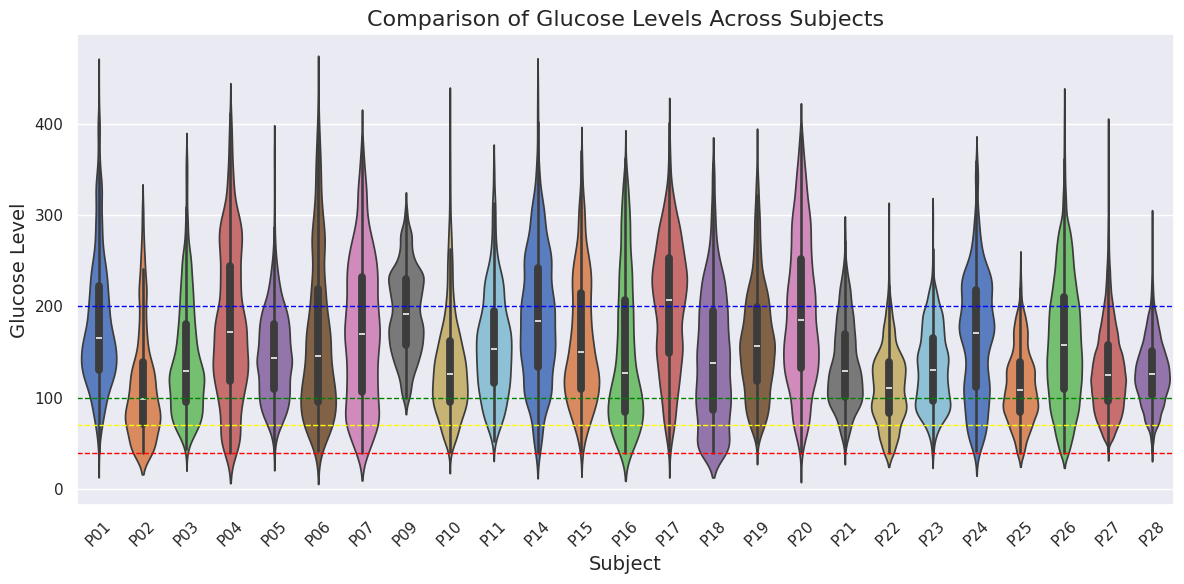

In [ ]:
# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='subj', y='glucose', data=df_all, palette='muted', hue='subj')

# Add vertical lines at 40 and 200
plt.axhline(y=40, color='red', linestyle='--', linewidth=1, label='Threshold: 40 - critical')
plt.axhline(y=70, color='yellow', linestyle='--', linewidth=1, label='Threshold: 70 - harmful')
plt.axhline(y=100, color='green', linestyle='--', linewidth=1, label='Threshold: 100 - normal')
plt.axhline(y=200, color='blue', linestyle='--', linewidth=1, label='Threshold: 200 - high')

# Customize the plot
plt.title('Comparison of Glucose Levels Across Subjects', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Glucose Level', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

# Show the plot
plt.tight_layout()
plt.show()

Yeah that are some pretty unhealthy levels of blood glucose ^^'

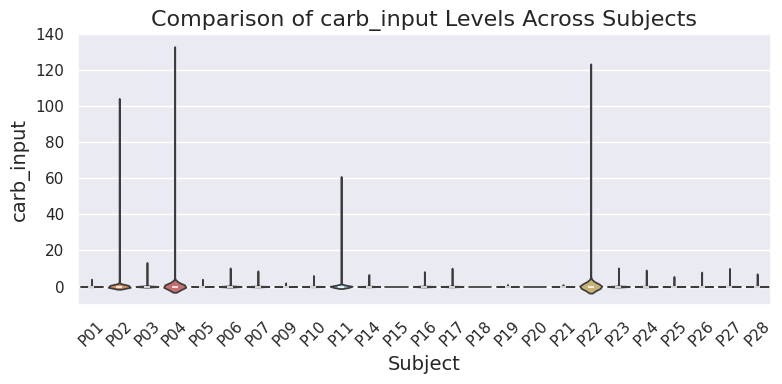

In [ ]:
var_name = 'carb_input'

plt.figure(figsize=(8, 4))
sns.violinplot(x='subj', y=var_name, data=df_all, palette='muted', hue='subj')

# Customize the plot
plt.title(f'Comparison of {var_name} Levels Across Subjects', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel(var_name, fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

# Show the plot
plt.tight_layout()
plt.show()

This show cases the scale difference for carb_input pretty well. Hard to use this feature...

# Preprocessing

We are about to:
- remove 'burned_calories', 'steps', 'carb_input' from the feature list, because they are multicolinear or just bad
- remove Subject P09, because his/her glucose data is really bad
- smooth the glucose data for subject P01 to remove the rippling effect
- add time features for hour of day, since the circadiane rhythm most likely has some influence (like being awake/sleeping)

In [ ]:
_subj_data = subj_data.copy()
# Remove Subject P09, because glucose data is bad
_subj_data.pop('P09')
# smooth glucose data for subject P01 to remove rippling effect
p1_fixed = get_subj('P01')
p1_fixed['glucose'] = p1_fixed['glucose'].rolling(3, center=True).mean()
p1_fixed = p1_fixed.iloc[1:-1]
_subj_data['P01'] = p1_fixed
# the end period for P27 is not tracked well, we don't want to use that as test set ^^'
_subj_data['P27'] = get_subj('P27').loc[:"2021-12-22"]

df = pd.concat(_subj_data.values()).reset_index()
#drop unused features
#df = df.drop(columns=['burned_calories', 'steps', 'carb_input'])
df = df.drop(columns=['steps', 'carb_input']) # keep burned_calories for gaps in heart_rate
# add time features
df['hour_of_day'] = df.time.dt.hour
df['hour_sin'] = np.sin(np.pi * df['hour_of_day'] / 12)
df['hour_cos'] = np.cos(np.pi * df['hour_of_day'] / 12)
df.round(3).head()

time subj  glucose  burned_calories  heart_rate  \
0 2018-06-13 18:45:00  P01  329.333            7.728      83.740   
1 2018-06-13 18:50:00  P01  326.667            4.750      80.525   
2 2018-06-13 18:55:00  P01  320.000            6.359      89.129   
3 2018-06-13 19:00:00  P01  314.333            5.152      92.496   
4 2018-06-13 19:05:00  P01  310.333            6.601      92.000   

   basal_insulin  bolus_insulin  hour_of_day  hour_sin  hour_cos  
0          0.092            0.0           18    -1.000    -0.000  
1          0.092            0.0           18    -1.000    -0.000  
2          0.092            0.0           18    -1.000    -0.000  
3          0.075            0.0           19    -0.966     0.259  
4          0.075            0.0           19    -0.966     0.259

The data was preprocessed and some (big) gaps were linearly interpolated. Especially for glucose and heart rate this does not seem like the best method. So we detect these periods (using a threshold on the second derivative) and mask them.

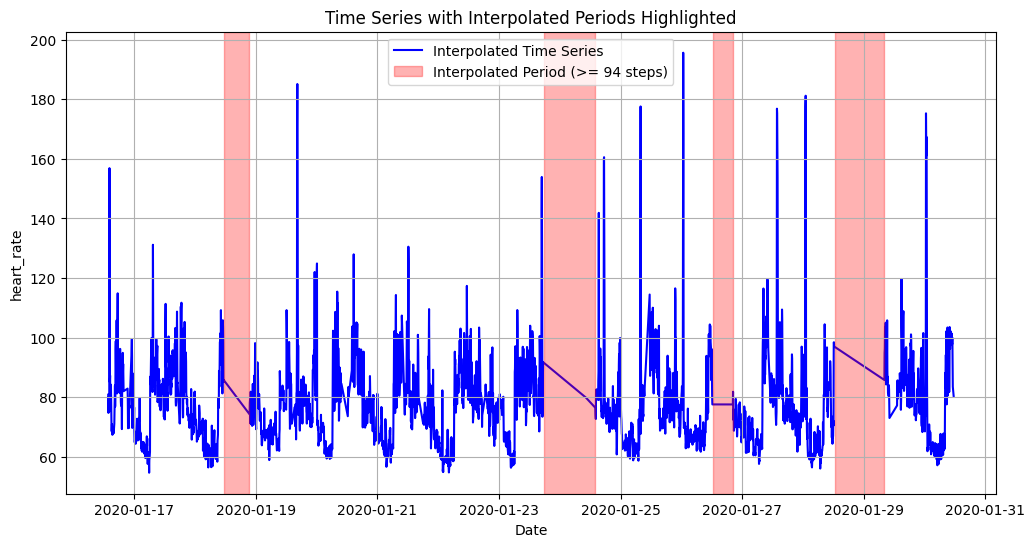

In [ ]:
ts = get_subj('P25', df).heart_rate
mask = approx_interpolated_periods(ts, 12*3, 0.1, smoothing_win=3)
plot_gaps(ts, mask)

In [ ]:
# for small gaps the linear interpolation is propably fine
min_gap_len = 12*3

df_gaps = df.copy()
for s in df_gaps.subj.unique():
    df_sub = df_gaps[df.subj == s]
    glucose_mask = approx_interpolated_periods(df_sub['glucose'], min_length=min_gap_len)
    if glucose_mask.sum() > 0:
        #print(f"Replace {glucose_mask.sum()} BG values with nan for subject {s}")
        df_sub.loc[glucose_mask, 'glucose'] = np.nan
    hr_mask = approx_interpolated_periods(df_sub['heart_rate'], min_length=min_gap_len,
                                          eps=.1, smoothing_win=3)
    if hr_mask.sum() > 0:
        #print(f"Replace {hr_mask.sum()} HR values with nan for subject {s}")
        df_sub.loc[hr_mask, 'heart_rate'] = np.nan

    df_gaps[df.subj == s] = df_sub
#print(df.isna().sum())

In [ ]:
gaps_info = df_gaps[['glucose', 'heart_rate']].isna().groupby(df_gaps.subj).agg(
    [('[#]', 'sum'), ('[%]', lambda x: 100*x.sum()/len(x))])
gaps_info.round(1)#.reorder_levels([1,0], axis=1)

glucose       heart_rate      
         [#]   [%]        [#]   [%]
subj                               
P01       42   1.0         63   1.5
P02       62   1.9          0   0.0
P03        0   0.0        189   5.0
P04      392  12.3       1440  45.2
P05        0   0.0       1593  41.3
P06        0   0.0          0   0.0
P07        0   0.0          0   0.0
P10      885  29.7       1277  42.9
P11        0   0.0          0   0.0
P14      543  14.2        242   6.3
P15        0   0.0          0   0.0
P16      403  10.5          0   0.0
P17       89   2.5        258   7.2
P18       38   1.0          0   0.0
P19        0   0.0        259   7.0
P20        0   0.0         87   3.0
P21        0   0.0          0   0.0
P22      147   3.7          0   0.0
P23        0   0.0          0   0.0
P24        0   0.0          0   0.0
P25       50   1.2        696  17.4
P26     4251  10.5       2244   5.5
P27     7227   4.6      20238  12.9
P28     1317   5.1        871   3.4

Seems like some subjects did not use the heart rate monitor correctly..

Let's visualize the results:

In [ ]:
id = 'P04'
temp_df = pd.concat([get_subj(id, df)[['glucose', 'heart_rate']],
                     get_subj(id, df_gaps)[['glucose', 'heart_rate']].add_suffix('_post')],
                    axis=1)
legend_groups = {'glucose': ['glucose', 'glucose_post'], 'heart_rate': ['heart_rate', 'heart_rate_post']}

show_interactive_ts_plot(temp_df, temp_df.columns, groups=legend_groups)

We can try to estimate the missing data (for heart rate) using the other variables (e.g. burned_calories, time) and lag features

In [ ]:
# Let's try to imputate heart rate using burned_calories, time features and lagged values for the last 5 days
df_gaps['heart_rate_imp'] = impute_with_lags(df_gaps, target='heart_rate', covariates=['burned_calories','hour_sin','hour_cos'],
                                          group_by='subj', max_past='5d', lag_step='24h')

In [ ]:
# works quite well if burned_calories is available
show_interactive_ts_plot(get_subj('P04', df_gaps), ['heart_rate_imp', 'heart_rate'])

In [ ]:
# else it at least adds some daily pattern (based on hour_sin)
show_interactive_ts_plot(get_subj('P05', df_gaps), ['heart_rate_imp', 'heart_rate'])

In [ ]:
_df = df_gaps

subj_list = _df.subj.unique().tolist()
#test_subjs = subj_list[:7]
#train_subjs = subj_list[7:]

test_subjs = [f'P{x:02d}' for x in [6, 7, 11, 15, 18, 21]] # use a curated list of high quality data as test set ;)
train_subjs = [x for x in subj_list if x not in test_subjs and x != 'P27']
print(f'Train subjects ({100 * _df.subj.isin(train_subjs).sum() / len(_df) :.2f}%): {train_subjs}')
print(f'Test subjects ({100 * _df.subj.isin(test_subjs).sum() / len(_df) :.2f}%): {test_subjs}')

train_multi = _df.loc[df.subj.isin(train_subjs)]
test_multi = _df.loc[df.subj.isin(test_subjs)]

p27 = get_subj('P27', _df)
ratio = 0.8
train_p27 = p27.iloc[:int(ratio*len(p27))]
test_p27 = p27.iloc[int(ratio*len(p27)):]
print(f'Train P27 ({100 * len(train_p27) / len(_df) :.2f}%)')
print(f'Test P27 ({100 * len(test_p27) / len(_df) :.2f}%)')

Train subjects (40.50%): ['P01', 'P02', 'P03', 'P04', 'P05', 'P10', 'P14', 'P16', 'P17', 'P19', 'P20', 'P22', 'P23', 'P24', 'P25', 'P26', 'P28']
Test subjects (6.74%): ['P06', 'P07', 'P11', 'P15', 'P18', 'P21']
Train P27 (42.21%)
Test P27 (10.55%)


In [ ]:
verbose=True
subj_data_fix = {s: remove_gap_days(get_subj(s, _df), drop_ratio=.5, verbose=verbose) for s in subj_list}
df_fix = pd.concat(subj_data_fix.values()).reset_index()
df_fix['glucose_imp'] = df_fix.groupby('subj').glucose.transform(pd.DataFrame.interpolate)

train_multi_fix = df_fix.loc[df.subj.isin(train_subjs)]
test_multi_fix = df_fix.loc[df.subj.isin(test_subjs)]
print(f'Train subjects ({100 * df_fix.subj.isin(train_subjs).sum() / len(df_fix) :.2f}%): {train_subjs}')
print(f'Test subjects ({100 * df_fix.subj.isin(test_subjs).sum() / len(df_fix) :.2f}%): {test_subjs}')


p27_fix = get_subj('P27', df_fix)
train_p27_fix = p27_fix.iloc[:int(ratio*len(p27_fix))]
test_p27_fix = p27_fix.iloc[int(ratio*len(p27_fix)):]
print(f'Train P27 (fix) ({100 * len(train_p27_fix) / len(_df) :.2f}%)')
print(f'Test P27 (fix) ({100 * len(test_p27_fix) / len(_df) :.2f}%)')

Removed 0 days with missing glucose data from P01
Removed 0 days with missing glucose data from P02
Removed 0 days with missing glucose data from P03
Removed 1 days with missing glucose data from P04
Removed 0 days with missing glucose data from P05
Removed 0 days with missing glucose data from P06
Removed 0 days with missing glucose data from P07
Removed 1 days with missing glucose data from P10
Removed 0 days with missing glucose data from P11
Removed 1 days with missing glucose data from P14
Removed 0 days with missing glucose data from P15
Removed 0 days with missing glucose data from P16
Removed 0 days with missing glucose data from P17
Removed 0 days with missing glucose data from P18
Removed 0 days with missing glucose data from P19
Removed 0 days with missing glucose data from P20
Removed 0 days with missing glucose data from P21
Removed 0 days with missing glucose data from P22
Removed 0 days with missing glucose data from P23
Removed 0 days with missing glucose data from P24


In [ ]:
legend_groups = {'heart_rate': ['heart_rate_imp', 'heart_rate'],
                 'glucose': ['glucose_imp', 'glucose']}
show_interactive_ts_plot(get_subj('P04', df_fix), ['heart_rate_imp', 'heart_rate', 'glucose_imp', 'glucose'],
                         groups=legend_groups)

In [ ]:
# Save as csv
out_folder = Path('Data')
out_folder.mkdir(parents=True, exist_ok=True)
train_multi.to_csv(out_folder / 'train_multi.csv', index=False)
test_multi.to_csv(out_folder / 'test_multi.csv', index=False)
train_p27.to_csv(out_folder / 'train_p27.csv', index=False)
test_p27.to_csv(out_folder / 'test_p27.csv', index=False)

In [ ]:
train_multi_fix.to_csv(out_folder / 'train_multi_no_gaps.csv', index=False)
test_multi_fix.to_csv(out_folder / 'test_multi_no_gaps.csv', index=False)
train_p27_fix.to_csv(out_folder / 'train_p27_no_gaps.csv', index=False)
test_p27_fix.to_csv(out_folder / 'test_p27_no_gaps.csv', index=False)

In [ ]:
from google.colab import files

!rm data.zip
!zip -r data.zip {out_folder} -x ".*"
files.download('data.zip')

  adding: Data/processed/ (stored 0%)
  adding: Data/processed/test_p27.csv (deflated 85%)
  adding: Data/processed/test_multi.csv (deflated 84%)
  adding: Data/processed/train_multi_no_gaps.csv (deflated 84%)
  adding: Data/processed/train_p27_no_gaps.csv (deflated 84%)
  adding: Data/processed/test_p27_no_gaps.csv (deflated 84%)
  adding: Data/processed/test_multi_no_gaps.csv (deflated 84%)
  adding: Data/processed/train_multi.csv (deflated 85%)
  adding: Data/processed/train_p27.csv (deflated 84%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>